# Анализ новой системы подбора рекомендаций в приложении по доставке продуктов

**импортируем основные библиотеки и задаем значение альфа:**

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, chi2
import seaborn as sns 

alpha = 0.05

In [7]:
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')
users = pd.read_csv('ab_users_data.csv')

**считаем данные и посмотрим на их структуру:**

In [8]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [9]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [10]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


**для более удобного отображения данных в анализе, присвоим каждой группе название:**

In [11]:
users['group_name'] = users.group.apply(lambda x: 'test' if x == 1 else 'control')
users.head()

,user_id,order_id,action,time,date,group,group_name
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,control
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,test
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,control
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,control
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,test


**посмотрим на возможные статусы заказов:**

In [12]:
users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

**посмотрим на число пользователей в каждой группе:**

In [13]:
users.groupby('group_name').user_id.nunique()

group_name
control    515
test       502
Name: user_id, dtype: int64

**число клиентов в каждой группе примерно одинаково.**

**посмотрим на число заказов в каждой группе:**

In [14]:
users.groupby('group_name').order_id.nunique()

group_name
control    1609
test       2514
Name: order_id, dtype: int64

**проверим, сколько дней длился тест:**

In [15]:
print(f'продолжительность эксперимента составила {users.date.nunique()} дней')

продолжительность эксперимента составила 14 дней


### сформулируем 3 основных метрики, по которым будем оценивать качество нового алгоритма: 
>**1. среднее число заказов**\
>**2. среднее число отмененных заказов в день**\
>**3. средний чек неотмененных заказов**

## Cреднее число заказов в день

**для оценки среднего числа заказов подготовим датасет с неотмененными заказами**

In [16]:
canceled_orders = users.query('action =="cancel_order"').order_id.unique()

In [17]:
complete_orders = users.query('order_id not in @canceled_orders')

In [18]:
complete_orders.head()

,user_id,order_id,action,time,date,group,group_name
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,control
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,test
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,control
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,test
5,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,control


In [19]:
control_ord_by_date = complete_orders.query('group_name =="control"').groupby('date').order_id.nunique().reset_index()

In [20]:
test_ord_by_date = complete_orders.query('group_name =="test"').groupby('date').order_id.nunique().reset_index()

In [21]:
print(f'среднее число заказов в день при старом алгоритме составляет {control_ord_by_date.order_id.mean()}, при новом алгоритме - {test_ord_by_date.order_id.mean()}')

среднее число заказов в день при старом алгоритме составляет 109.07142857142857, при новом алгоритме - 170.14285714285714


**посмотрим на распределение получившихся данных по группам:**

Text(0, 0.5, 'число дней')

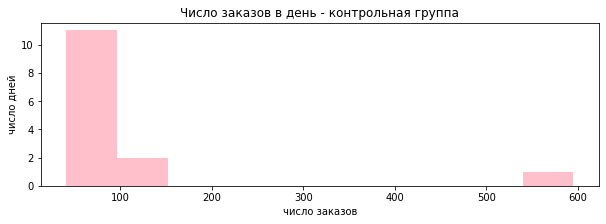

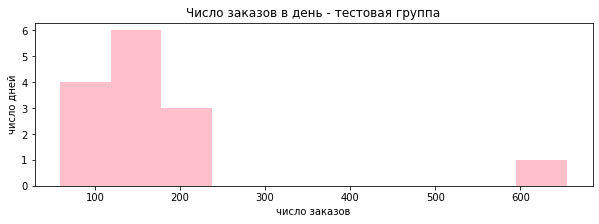

In [22]:
plt.figure(figsize=(10,3))
plt.hist(control_ord_by_date.order_id, 10, color='pink')
plt.title('Число заказов в день - контрольная группа')
plt.xlabel('число заказов')
plt.ylabel('число дней')

plt.figure(figsize=(10,3))
plt.hist(test_ord_by_date.order_id, 10, color='pink')
plt.title('Число заказов в день - тестовая группа')
plt.xlabel('число заказов')
plt.ylabel('число дней')


**проверим нормальность распределения для каждой группы:**

In [23]:
print('для контрольной группы: ', ss.shapiro(control_ord_by_date.order_id))
print('для тестовой группы: ', ss.shapiro(test_ord_by_date.order_id))

для контрольной группы:  ShapiroResult(statistic=0.43553799390792847, pvalue=1.9268536561867222e-06)
для тестовой группы:  ShapiroResult(statistic=0.5954262018203735, pvalue=3.6935518437530845e-05)


**Визуально и из теста видно, что распределения в обеих группах ненормальные с наличием сильных выбросов. Число наблюдений для каждой группы менее 30, поэтому в качестве проверки нулевой гипотезы попробуем применить непараметрический тест Манна-Уитни:**

In [24]:
stats_1, p_1 = ss.mannwhitneyu(control_ord_by_date.order_id, test_ord_by_date.order_id)

if p_1 <alpha:
    print(f'тест Манна-Уитни определил p-уровень значимости ниже порогового значения, из чего мы можем сделать вывод, что при новом алгоритме обнаружен статистически значимый рост числа заказов в день')
    print('p-value: ', p_1)
else: 
    print(f'тест Манна-Уитни определил p-уровень значимости выше порогового значения, статистически значимых различий в числе ежедневных заказов обнаружить не удалось')
    print('p-value: ', p_1)

тест Манна-Уитни определил p-уровень значимости ниже порогового значения, из чего мы можем сделать вывод, что при новом алгоритме обнаружен статистически значимый рост числа заказов в день
p-value:  0.00352648665061584


## Среднее число отмененных заказов

**для оценки числа отмененных заказов разделим все заказы в группах на отмененные и неотмененные:**

In [25]:
orders_type = users[['order_id', 'group_name']].drop_duplicates()

In [26]:
orders_type['order_group'] = orders_type.order_id.apply(lambda x: 'canceled' if x in canceled_orders else 'completed')

In [27]:
orders_type.head()

,order_id,group_name,order_group
0,1255,control,completed
1,1256,test,completed
2,1257,control,completed
3,1258,control,canceled
4,1259,test,completed


**поскольку мы проверяем данные по двум качественным критериям (отменен/завершен и тест/контроль), применим Хи-квадрат:**

In [28]:
pd.crosstab(orders_type.group_name, 
            orders_type.order_group)

order_group,canceled,completed
group_name,,
control,82,1527
test,132,2382


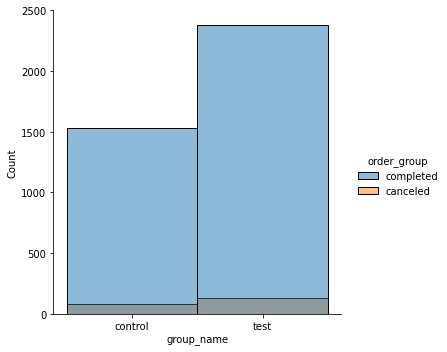

In [29]:
sns.displot(data=orders_type, x='group_name', hue='order_group')

In [30]:
stat_2, p_2, dof, expected = chi2_contingency(pd.crosstab(orders_type.group_name, orders_type.order_group))
if p_2 < alpha:
    print('p-value: ', p_2)
    print('p-value при Хи-квартате ниже порогового значения, число отмененных заказов с новым алгоритмом статистически значимо сократилось относительно прошлой версии')
else:
    print('p-value: ', p_2)
    print('p-value при Хи-квартате выше порогового значения, не обнаружено статистически значимых различий в числе отмененых заказов между двумя алгоритмами')

p-value:  0.8840344321879333
p-value при Хи-квартате выше порогового значения, не обнаружено статистически значимых различий в числе отмененых заказов между двумя алгоритмами


  

**попробуем посмотреть на долю отмененных заказов по дням:**

In [31]:
orders_type_by_date = users[['order_id','date', 'group_name']].drop_duplicates()

In [32]:
orders_type_by_date['order_group'] = orders_type_by_date.order_id.apply(lambda x: 'canceled' if x in canceled_orders else 'completed')

In [33]:
canceled_by_date_test = orders_type_by_date.query('group_name=="test" and order_group=="canceled"').groupby('date').order_id.count().reset_index()

In [34]:
canceled_by_date_control = orders_type_by_date.query('group_name=="control"').pivot_table(index = 'date', columns = 'order_group', values = 'order_id', aggfunc = "count")
canceled_by_date_control['canceled_share'] = canceled_by_date_control.canceled / (canceled_by_date_control.completed + canceled_by_date_control.canceled) 
canceled_by_date_control

order_group,canceled,completed,canceled_share
date,,,
2022-08-26,33.0,595.0,0.052548
2022-08-27,7.0,105.0,0.062500
2022-08-28,3.0,89.0,0.032609
2022-08-29,10.0,102.0,0.089286
2022-08-30,2.0,96.0,0.020408
2022-08-31,3.0,64.0,0.044776
2022-09-01,6.0,70.0,0.078947
2022-09-02,5.0,72.0,0.064935
2022-09-03,4.0,62.0,0.060606


In [35]:
canceled_by_date_test = orders_type_by_date.query('group_name=="test"').pivot_table(index = 'date', columns = 'order_group', values = 'order_id', aggfunc = "count")
canceled_by_date_test['canceled_share'] = canceled_by_date_test.canceled / (canceled_by_date_test.completed + canceled_by_date_test.canceled) 
canceled_by_date_test

order_group,canceled,completed,canceled_share
date,,,
2022-08-26,34,655,0.049347
2022-08-27,9,186,0.046154
2022-08-28,9,200,0.043062
2022-08-29,14,216,0.060870
2022-08-30,10,151,0.062112
2022-08-31,6,119,0.048000
2022-09-01,10,126,0.073529
2022-09-02,6,134,0.042857
2022-09-03,11,140,0.072848


In [36]:
print(f'среднее доля отмен в день при старом алгоритме составляет {canceled_by_date_control.canceled_share.mean()}, при новом алгоритме - {canceled_by_date_test.canceled_share.mean()}')

среднее доля отмен в день при старом алгоритме составляет 0.05169043518245379, при новом алгоритме - 0.053562692882724305


**проверим нормальность распределения для каждой группы:**

In [37]:
print('для контрольной группы: ', ss.shapiro(canceled_by_date_control.canceled_share.dropna()))
print('для тестовой группы: ', ss.shapiro(canceled_by_date_test.canceled_share))

для контрольной группы:  ShapiroResult(statistic=0.9748955965042114, pvalue=0.9450478553771973)
для тестовой группы:  ShapiroResult(statistic=0.9267581701278687, pvalue=0.27465662360191345)


**в соответствии с результатами теста, распределения нормальные, для сравнения средних применим t-test:**

In [38]:
stat_3, p_3 = ss.ttest_ind(a=canceled_by_date_control.canceled_share.dropna(), b=canceled_by_date_test.canceled_share.dropna(), equal_var=True)
p_3
if p_3 < alpha:
    print(f't-test определил p-уровень значимости ниже порогового значения, из чего мы можем сделать вывод, что при новом алгоритме обнаружено статистически значимое снижение доле отмененных заказов')
    print('p-value: ', p_3)
else:
    print(f't-test определил p-уровень значимости выше порогового значения, статистически значимых различий в доле отмененных заказов обнаружить не удалось')
    print('p-value: ', p_3)

t-test определил p-уровень значимости выше порогового значения, статистически значимых различий в доле отмененных заказов обнаружить не удалось
p-value:  0.78480654716492


## Средний чек неотмененных заказов 

**для оценки среднего чека необходимо подготовить данные:**

In [39]:
complete_orders.head() # работаем только с неотмененными заказами

,user_id,order_id,action,time,date,group,group_name
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,control
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,test
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,control
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,test
5,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,control


**по каждому заказу необходимо расчитать его стоимость:**

In [40]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [41]:
orders['product_ids'] = orders['product_ids'].apply(lambda x: x.replace('}','')).apply(lambda x: x.replace('{',''))

In [42]:
orders['product_ids'] = orders['product_ids'].str.split(',')
orders_detailed = orders.explode('product_ids').rename(columns ={'product_ids':'product_id'})
orders_detailed['product_id'] = orders_detailed['product_id'].astype(int)

In [43]:
orders_detailed.head()

,order_id,creation_time,product_id
0,1255,2022-08-26 00:00:19.000000,75
0,1255,2022-08-26 00:00:19.000000,22
0,1255,2022-08-26 00:00:19.000000,53
0,1255,2022-08-26 00:00:19.000000,84
1,1256,2022-08-26 00:02:21.000000,56


In [44]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


**объединим информацию по составу заказа и стоимости каждого товара:**

In [46]:
orders_detailed_with_revenue = pd.merge(orders_detailed, products, on ='product_id', how = 'left')

**соберем информацию по стоимости каждого заказа:**

In [47]:
orders_detailed_with_revenue.head()

,order_id,creation_time,product_id,name,price
0,1255,2022-08-26 00:00:19.000000,75,сок ананасовый,120.0
1,1255,2022-08-26 00:00:19.000000,22,сок мультифрукт,120.0
2,1255,2022-08-26 00:00:19.000000,53,мука,78.3
3,1255,2022-08-26 00:00:19.000000,84,мандарины,90.4
4,1256,2022-08-26 00:02:21.000000,56,сосиски,150.0


In [48]:
orders_detailed_with_revenue = orders_detailed_with_revenue.groupby('order_id').agg({'price':'sum'}).rename(columns ={'price':'revenue'})

**в основную таблицу с заказами добавим их стоимость:**

In [49]:
complete_orders_with_revenue = pd.merge(complete_orders, orders_detailed_with_revenue, on='order_id', how='left')
complete_orders_with_revenue.head()

,user_id,order_id,action,time,date,group,group_name,revenue
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,control,408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,test,250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,control,310.2
3,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,test,228.0
4,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,control,430.7


In [50]:
avg_check_control = complete_orders_with_revenue.query('group=="0"').revenue.reset_index()
avg_check_test = complete_orders_with_revenue.query('group=="1"').revenue.reset_index()

In [51]:
print(f'средний чек при старом алгоритме составляет {avg_check_control.revenue.mean()}, при новом алгоритме - {avg_check_test.revenue.mean()}')

средний чек при старом алгоритме составляет 382.09292730844794, при новом алгоритме - 368.86162888329136


Text(0, 0.5, 'число дней')

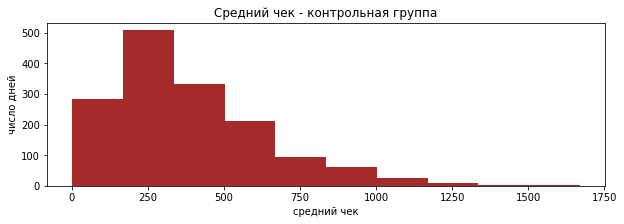

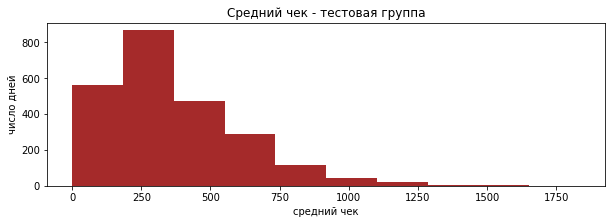

In [52]:
plt.figure(figsize=(10,3))
plt.hist(avg_check_control.revenue, 10, color='brown')
plt.title('Средний чек - контрольная группа')
plt.xlabel('средний чек')
plt.ylabel('число дней')

plt.figure(figsize=(10,3))
plt.hist(avg_check_test.revenue, 10, color='brown')
plt.title('Средний чек - тестовая группа')
plt.xlabel('средний чек')
plt.ylabel('число дней')


**проверим нормальность распределения для каждой группы:**

In [53]:
print('для контрольной группы: ', ss.shapiro(avg_check_control.revenue))
print('для тестовой группы: ', ss.shapiro(avg_check_test.revenue))

для контрольной группы:  ShapiroResult(statistic=0.9170262217521667, pvalue=3.811183766866527e-28)
для тестовой группы:  ShapiroResult(statistic=0.9005318880081177, pvalue=8.388620126125922e-37)


**По результату теста делаем вывод, что оба распределения нельзя отнести к нормальным, однако поскольку число наблюдений в каждой группе > 30, можем применить для сравнения средних t-test:**

In [54]:
stat_4, p_4 = ss.ttest_ind(a=avg_check_control.revenue, b=avg_check_test.revenue, equal_var=True)
p_4
if p_4 < alpha:
    print(f't-test определил p-уровень значимости ниже порогового значения, из чего мы можем сделать вывод, что при новом алгоритме обнаружен статистически значимый рост среднего чека')
    print('p-value: ', p_4)
else:
    print(f't-test определил p-уровень значимости выше порогового значения, статистически значимых различий в среднем чеке обнаружить не удалось')
    print('p-value: ', p_4)

t-test определил p-уровень значимости выше порогового значения, статистически значимых различий в среднем чеке обнаружить не удалось
p-value:  0.10244707728234669


## Итого, сведем результаты всех метрик:

In [55]:
print('Метрика: среднее число заказов в день')
print('Используемый тест: Манна-Уитни.')
print(f'P-value: {p_1}.') 
print('Эффект: +: Стат. значимый рост.')
print(' ')
print('Метрика: среднее число отмененных заказов')
print('Используемый тест: хи-квадрат.')
print(f'P-value: {p_2}.') 
print('Эффект: -: Стат. значимых различий не обнаружено.')
print(' ')
print('Метрика: доля отмененных заказов в день')
print('Используемый тест: t-test.')
print(f'P-value: {p_3}.') 
print('Эффект: -: Стат. значимых различий не обнаружено.')
print(' ')
print('Метрика: средний чек неотмененных заказов')
print('Используемый тест: t-test.')
print(f'P-value: {p_4}.') 
print('Эффект: -: Стат. значимых различий не обнаружено.')

Метрика: среднее число заказов в день
Используемый тест: Манна-Уитни.
P-value: 0.00352648665061584.
Эффект: +: Стат. значимый рост.
 
Метрика: среднее число отмененных заказов
Используемый тест: хи-квадрат.
P-value: 0.8840344321879333.
Эффект: -: Стат. значимых различий не обнаружено.
 
Метрика: доля отмененных заказов в день
Используемый тест: t-test.
P-value: 0.78480654716492.
Эффект: -: Стат. значимых различий не обнаружено.
 
Метрика: средний чек неотмененных заказов
Используемый тест: t-test.
P-value: 0.10244707728234669.
Эффект: -: Стат. значимых различий не обнаружено.


# Заключение
>По результатам АБ-теста **удалось обнаружить стат. значимый рост числа заказов в день**, однако изменения в алгоритме **не
повлияли на средний чек и долю отмененных заказов**. Из этого можно сделать вывод, что для бизнеса новый алгоритм может
принести больше прибыли путем увеличения количества заказов, но не путем увеличения среднего чека; пользователи стали чаще
делать заказы, однако новая система никак не влияет на процент отмененных заказов. По результатам теста нельзя однозначно 
оценить характер влияния новой системы, решение должно зависеть от цели бизнеса. Возможно стоит продлить тест, т.к. его 
текущие результаты собраны по 2м неделям эксперимента, этого может быть недостаточно для выявления стат. значимых
изменений. Также перед раскатыванием новой системы на всех пользователей стоит оценить риски роста числа заказов без роста
среднего чека и без снижения процента отмен. Вероятно рост числа заказов может негативно повлиять на логистику,
время доставки, удовлетворенность клиентов и лояльность. 